In [ ]:
%pip install tensorflow
%pip install keras

In [28]:
import tensorflow as tf

from keras import datasets, layers, models
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate, concatenate
import matplotlib.pyplot as plt

![inception module diagram](inception_module_diagram.png)

Image from C. Szegedy et al: [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)

The below function implements the Inception module with dimensions (pictured above on the right)

In [22]:
# Inception model with dimension Reductions

def inception_module(model, f1_conv1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4_pool):
    path1 = Conv2D(filters=f1_conv1, kernel_size=(1, 1), activation='relu', padding='same')(model)

    path2 = Conv2D(filters=f2_conv1, kernel_size=(1, 1), activation='relu', padding='same')(model)
    path2 = Conv2D(filters=f2_conv3, kernel_size=(3, 3), activation='relu', padding='same')(path2)

    path3 = Conv2D(filters=f3_conv1, kernel_size=(1, 1), activation='relu', padding='same')(model)
    path3 = Conv2D(filters=f3_conv5, kernel_size=(5, 5), activation='relu', padding='same')(path3)

    path4 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(model)
    path4 = Conv2D(filters=f4_pool, kernel_size=(1, 1), activation='relu', padding='same')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

![GoogleLeNet model table](GoogLeNet_model_parameters_table.png)

Image from C. Szegedy et al: [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)

Below implements the GoogLeNet Model with parameters shown in the above table

Implementation based on [Khuyen Le's implementation](https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c)

In [25]:
# GoogLeNet Model
input = Input(shape=(224, 224, 3)) # 32x32 input layer because of CIFAR-10 image size

# First Convolutional Layer
x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input)

# First Max Pooling Layer
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)

x = inception_module(model=x, f1_conv1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4_pool=32)
x = inception_module(model=x, f1_conv1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4_pool=64)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(model=x, f1_conv1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4_pool=64)
x = inception_module(model=x, f1_conv1=160, f2_conv1=112, f2_conv3=224, f3_conv1=24, f3_conv5=64, f4_pool=64)
x = inception_module(model=x, f1_conv1=128, f2_conv1=128, f2_conv3=256, f3_conv1=24, f3_conv5=64, f4_pool=64)
x = inception_module(model=x, f1_conv1=112, f2_conv1=144, f2_conv3=288, f3_conv1=32, f3_conv5=64, f4_pool=64)
x = inception_module(model=x, f1_conv1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4_pool=128)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(model=x, f1_conv1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4_pool=128)
x = inception_module(model=x, f1_conv1=384, f2_conv1=192, f2_conv3=384, f3_conv1=48, f3_conv5=128, f4_pool=128)

x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)

x = Dropout(0.4)(x)
x = Dense(1000, activation='softmax')(x)
  
# GoogLeNet Model
model = Model(input, [x], name='GoogLeNet')

In [ ]:
model.summary()

In [37]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [38]:
import os
import math
import cv2

import numpy as np
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt


Dataset taken from Xhlulu's Kaggle: [Humpback Whale Identification](https://www.kaggle.com/code/xhlulu/exploration-and-preprocessing-for-keras-224x224/data)

In [39]:
label_df = pd.read_csv('data/train.csv')
label_df.head()


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [45]:
label_df['Id'].describe()


count         25361
unique         5005
top       new_whale
freq           9664
Name: Id, dtype: object

In [48]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def pad_and_resize_cv(image_path, dataset, desired_size=224):
    img = cv2.imread(f'data/{dataset}/{image_path}')
    
    pad_width = get_pad_width(img, max(img.shape))
    padded = np.pad(img, pad_width=pad_width, mode='constant', constant_values=0)
    
    resized = cv2.resize(padded, (desired_size,)*2).astype('uint8')
    
    return resized

def pad_and_resize_pil(image_path, dataset, desired_size=224):
    '''Experimental'''
    im = Image.open(f'data/{dataset}/{image_path}')
    
    old_size = im.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    resized = im.resize(new_size)
    im_array = np.asarray(resized)
    
    pad_width = get_pad_width(im_array, desired_size)
    padded = np.pad(im_array, pad_width=pad_width, mode='constant', constant_values=0)
    
    return padded


def pad_and_resize(image_path, dataset, desired_size=224, mode='cv'):
    if mode =='pil':
        return pad_and_resize_pil(image_path, dataset, desired_size)
    else:
        return pad_and_resize_cv(image_path, dataset, desired_size)

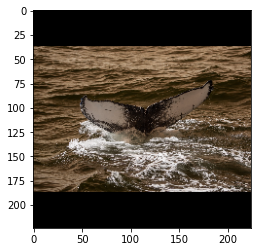

In [50]:
img = cv2.imread(f'data/train/{label_df.loc[0,"Image"]}') 

pad_width = get_pad_width(img, max(img.shape))
padded = np.pad(img, pad_width=pad_width, mode='constant', constant_values=0)
resized = cv2.resize(padded, (224,224))
plt.imshow(resized)

In [59]:
train_resized_imgs = []

for image_path in label_df['Image']:
    train_resized_imgs.append(pad_and_resize(image_path, 'train'))

In [55]:
test_resized_imgs = []

submission_df = pd.read_csv('data/test.csv')

for image_path in submission_df['Image']:
    test_resized_imgs.append(pad_and_resize(image_path, 'test'))

In [60]:
X_train = np.stack(train_resized_imgs)
X_test = np.stack(test_resized_imgs)

print("X_train", X_train.shape)
print("X_test", X_test.shape)

target_dummies = pd.get_dummies(label_df['Id'])
train_label = target_dummies.columns.values
y_train = target_dummies.values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

X_train (25361, 224, 224, 3)
X_test (7960, 224, 224, 3)
(25361, 224, 224, 3)
(7960, 224, 224, 3)
(25361, 5005)


In [61]:
np.save('X_train.npy', X_train)

In [62]:
model(X_train, training=True)